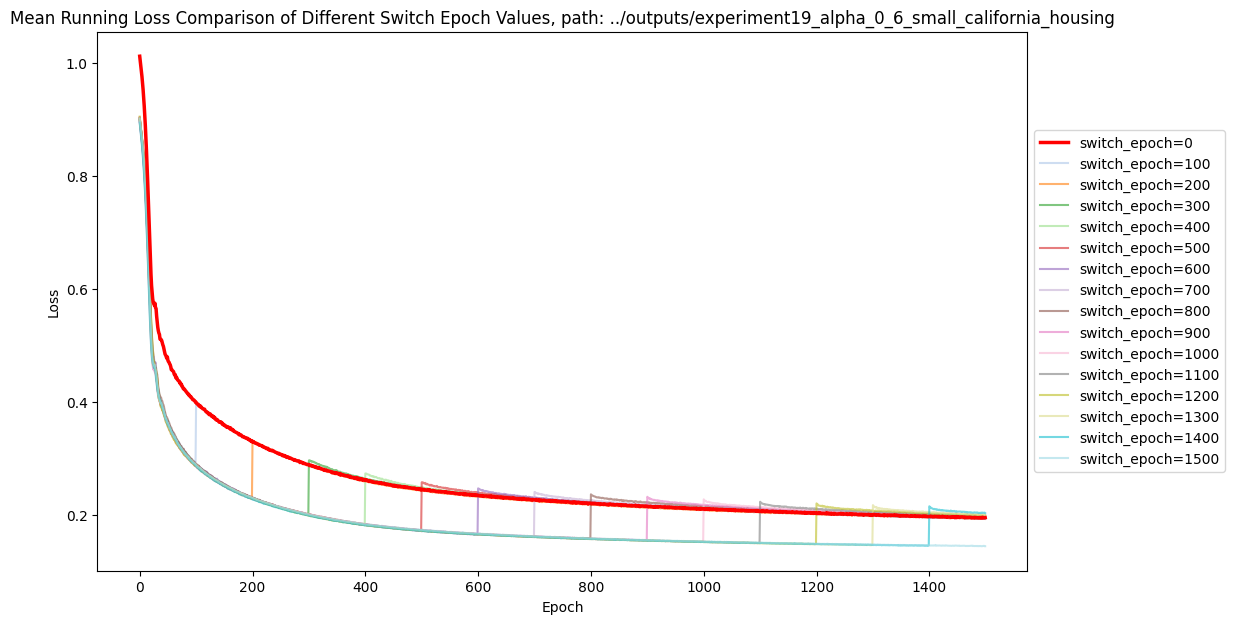

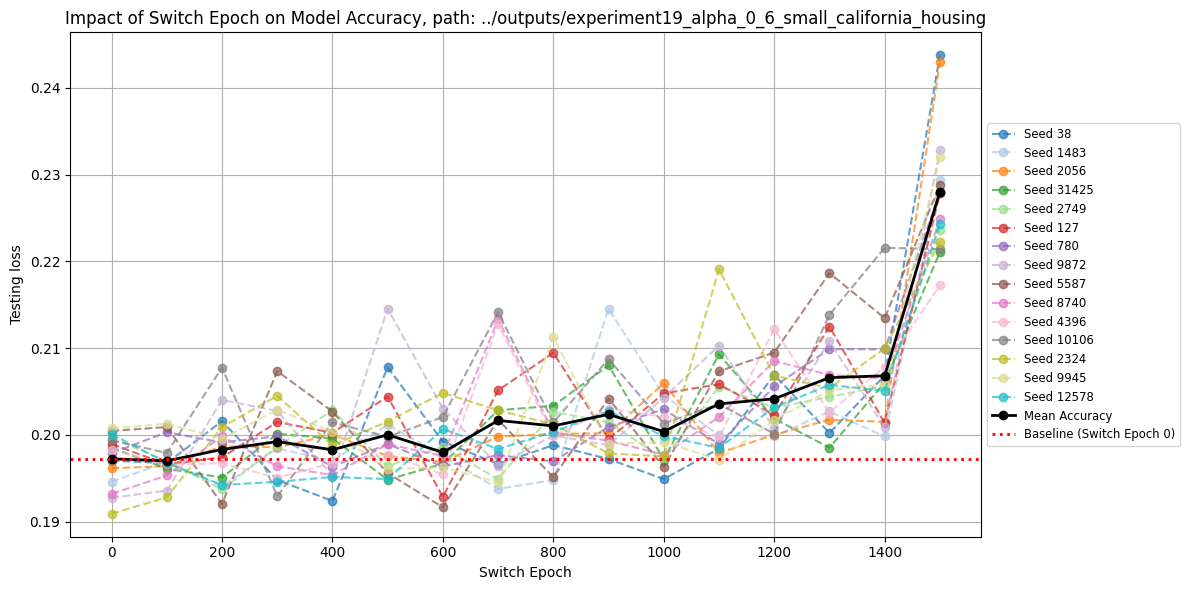

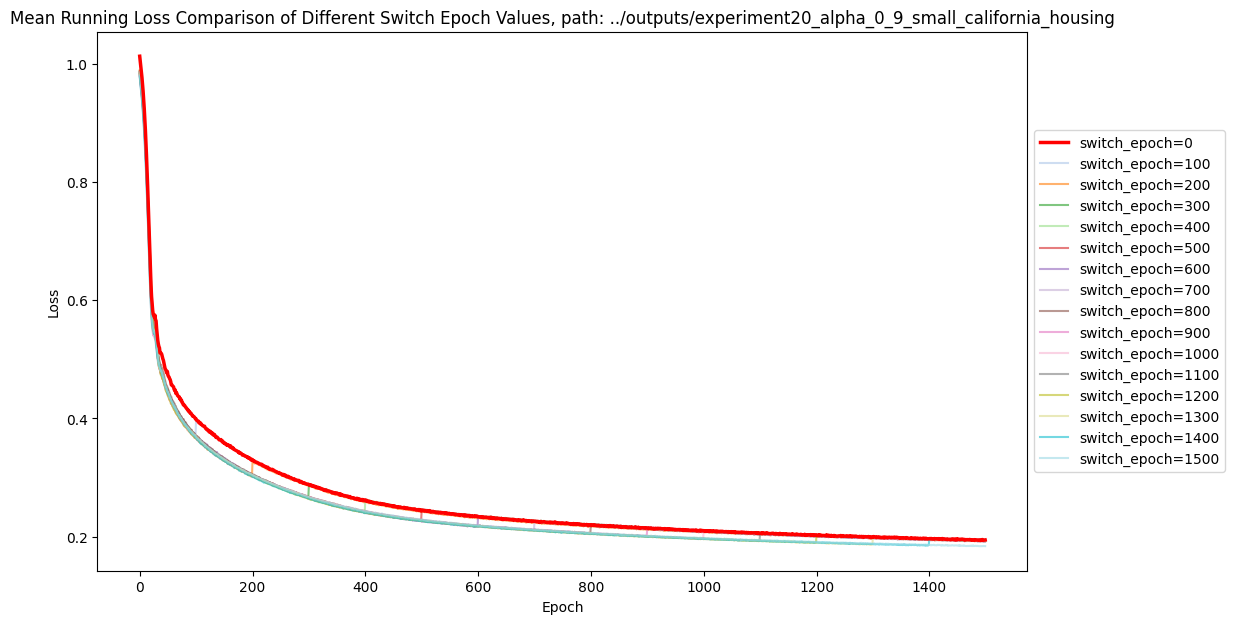

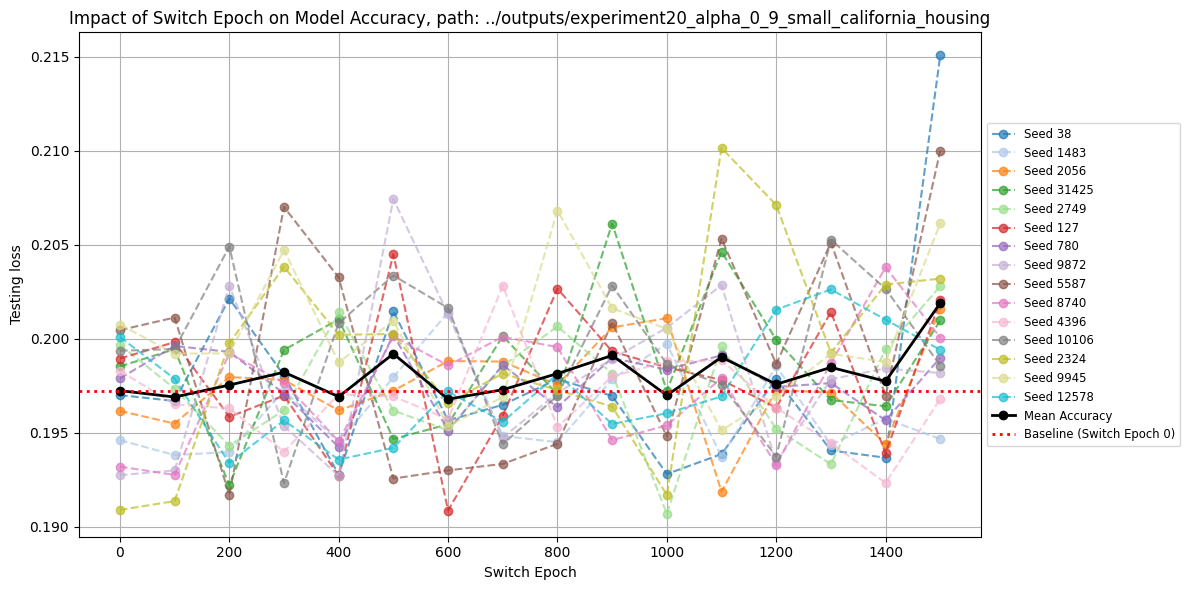

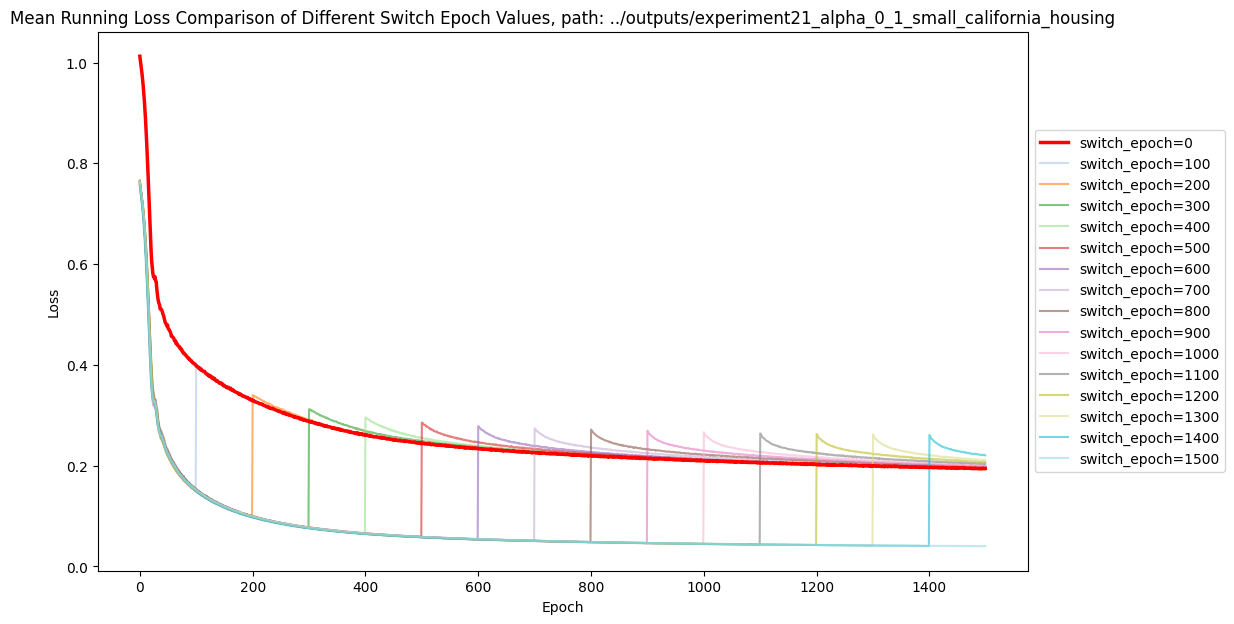

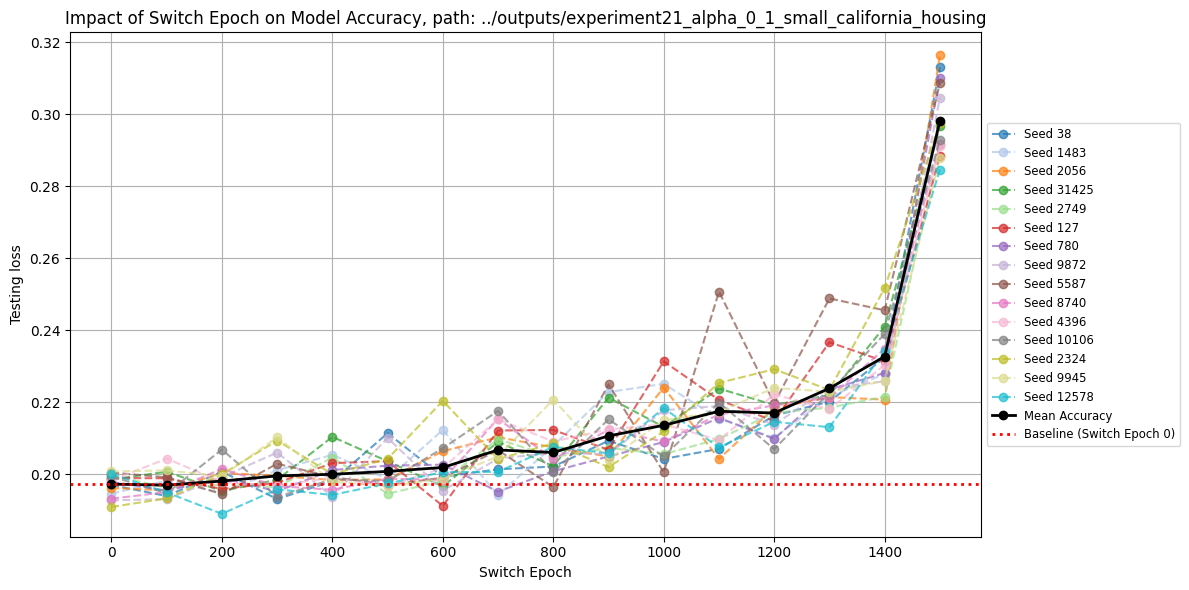

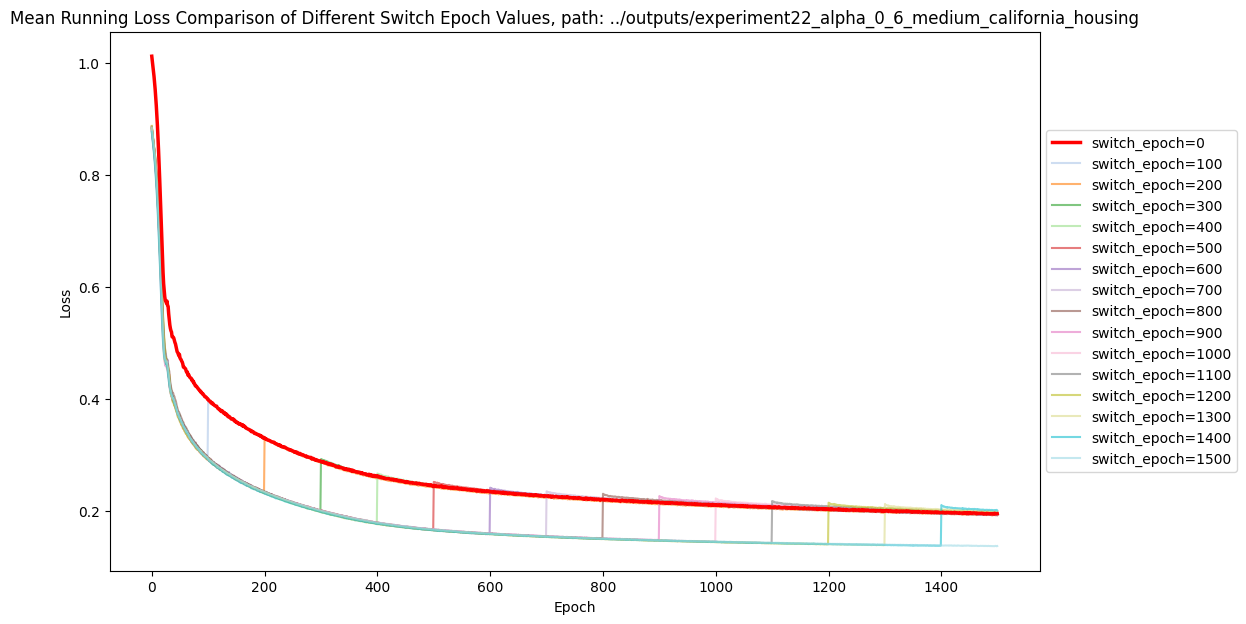

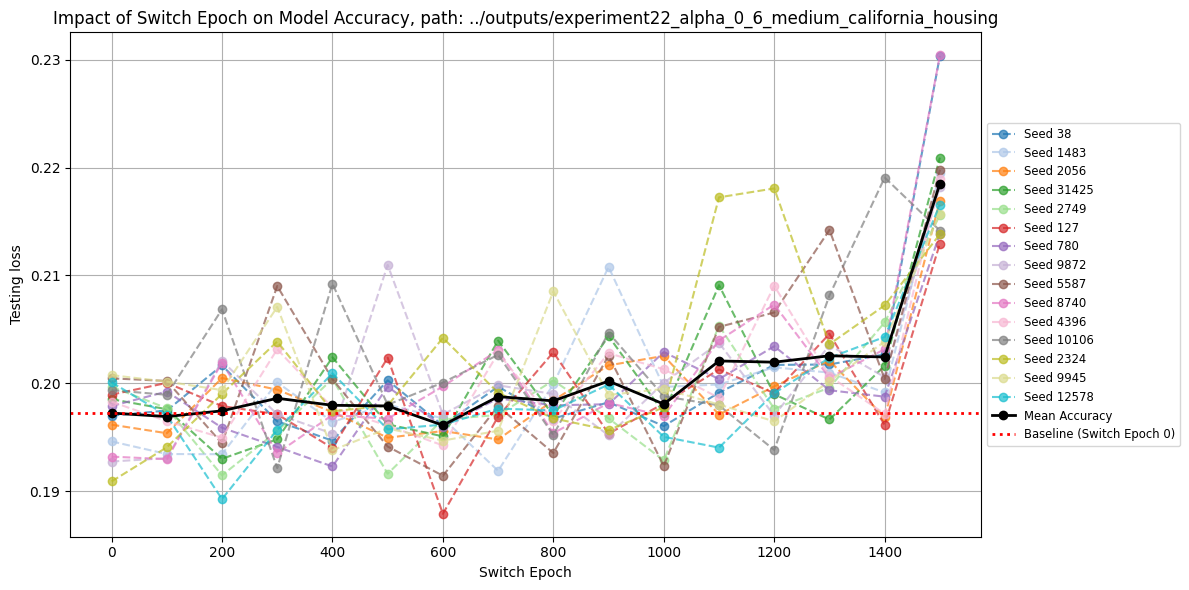

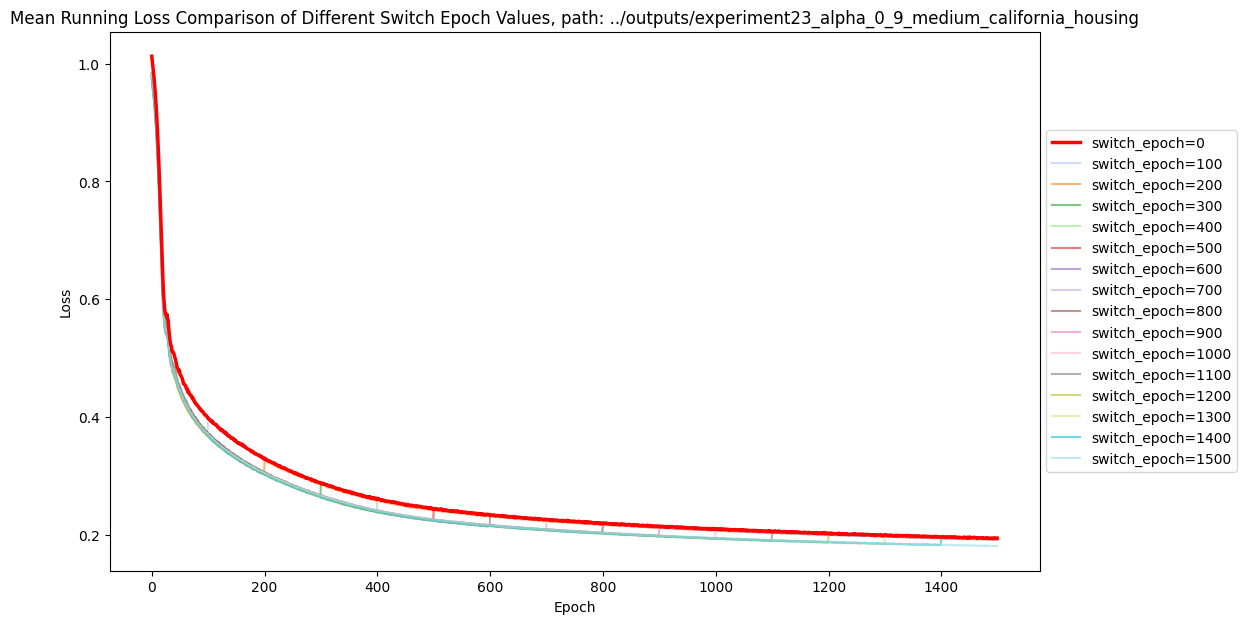

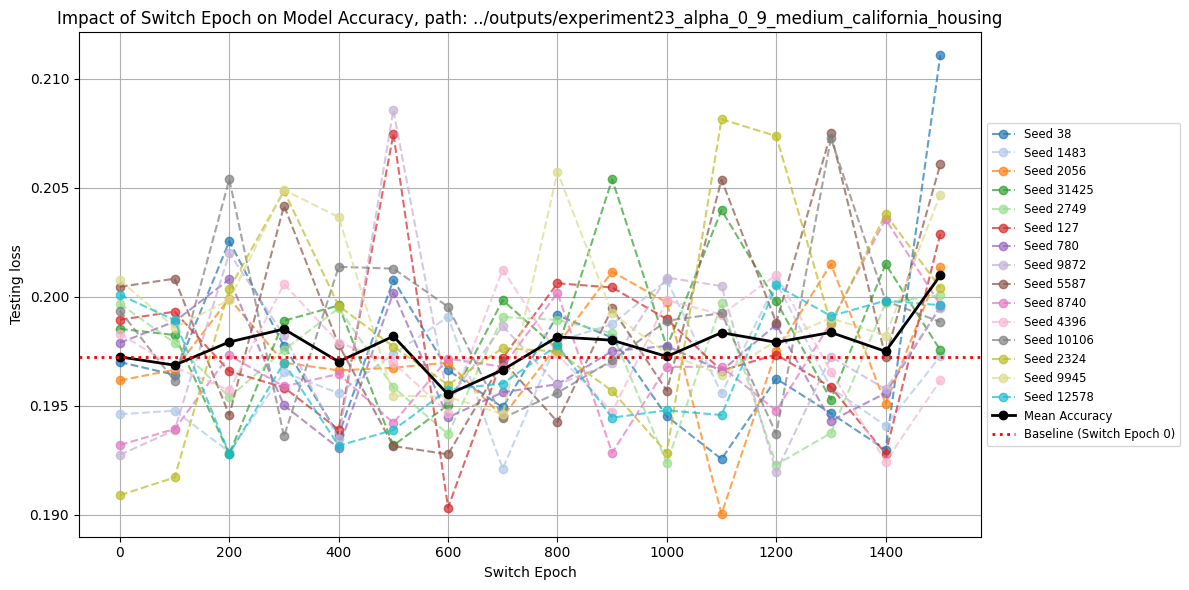

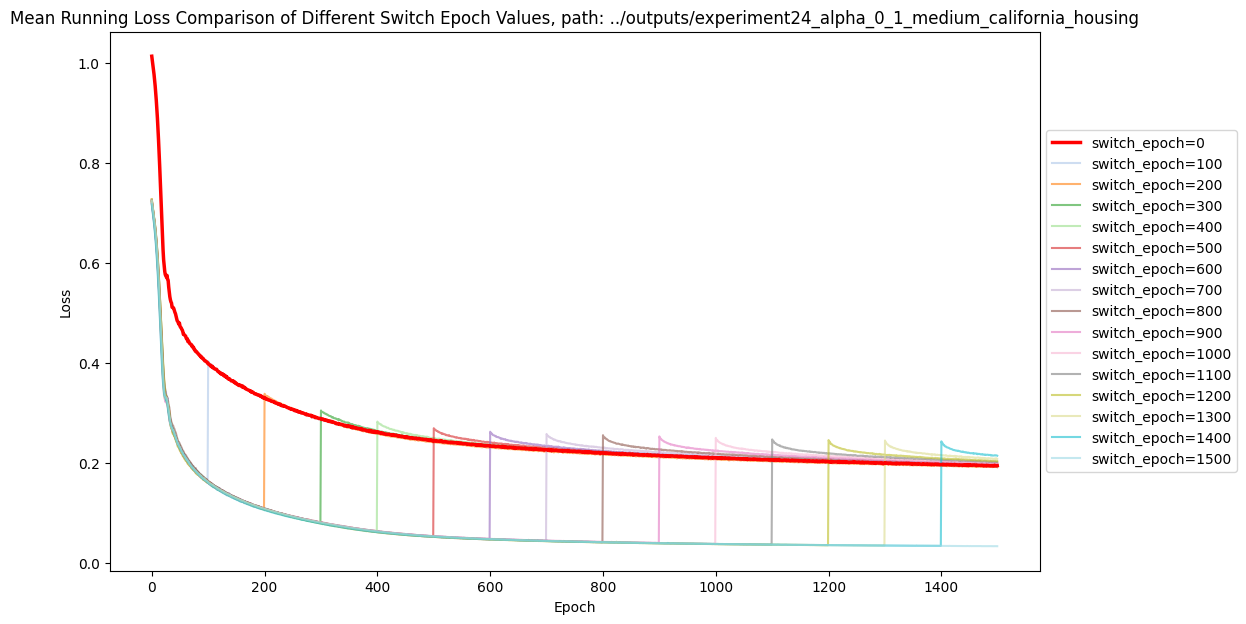

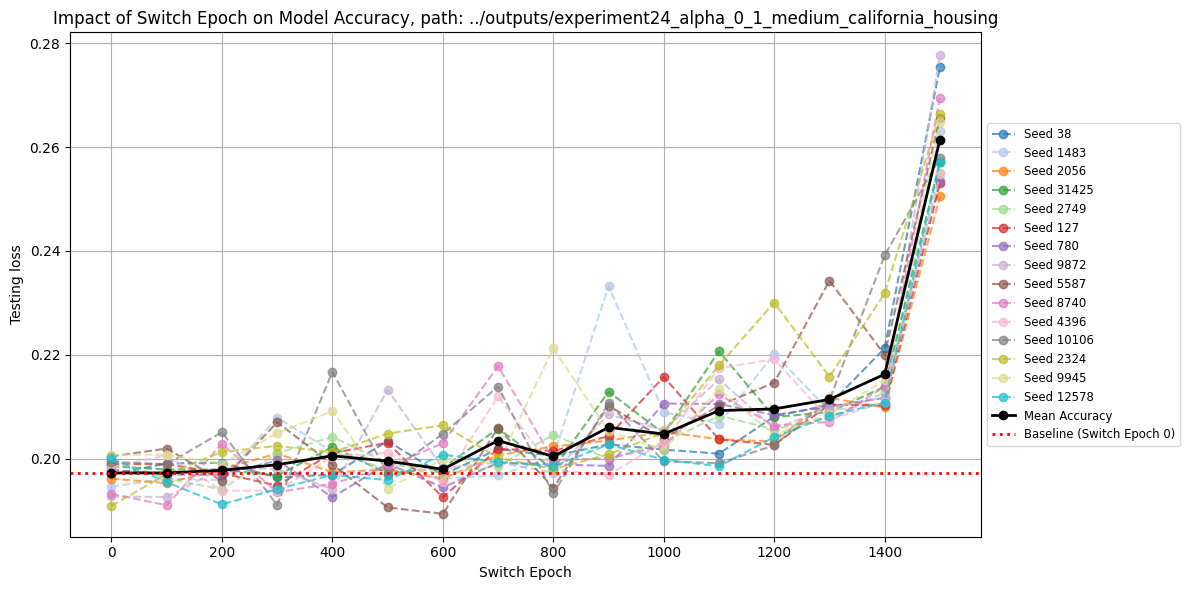

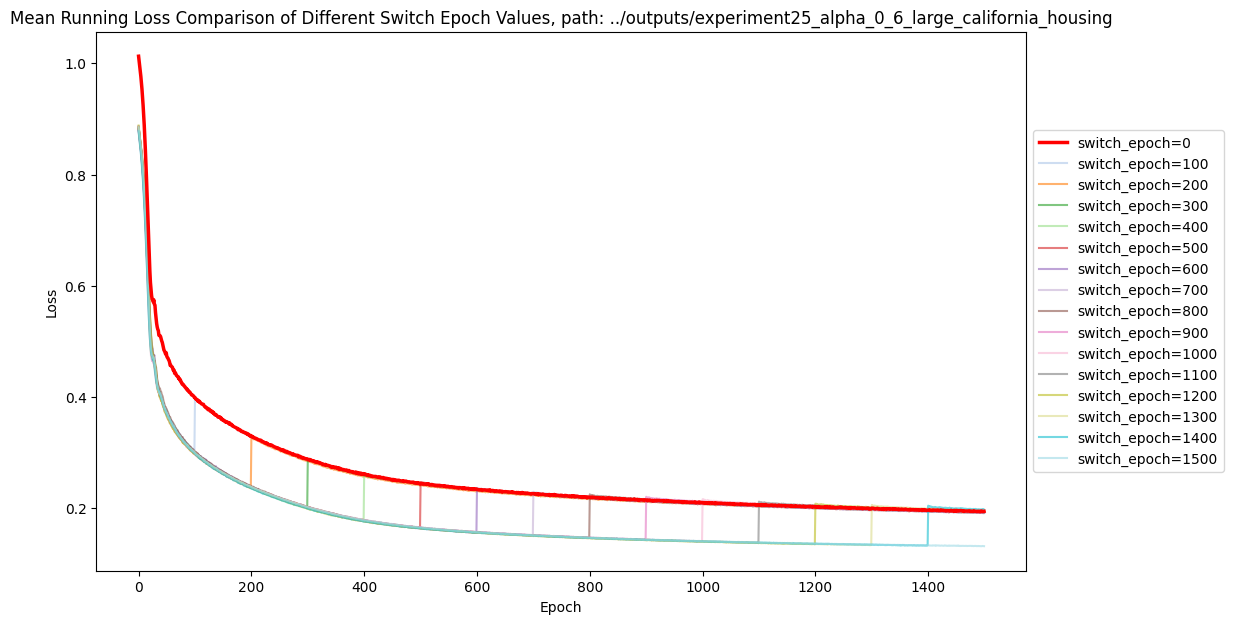

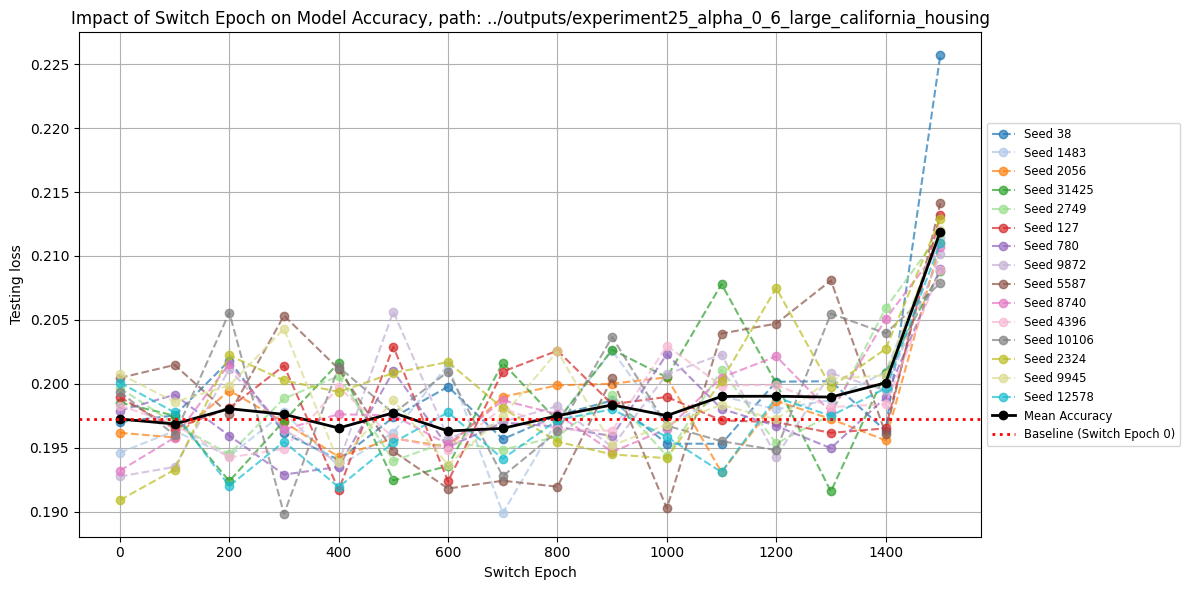

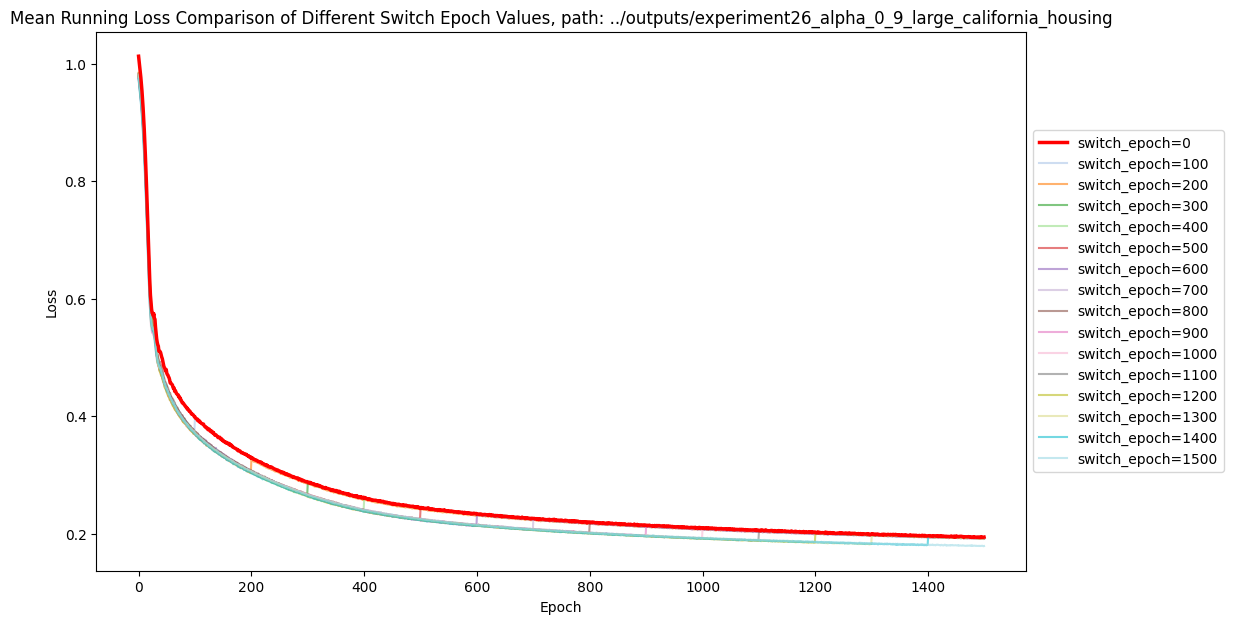

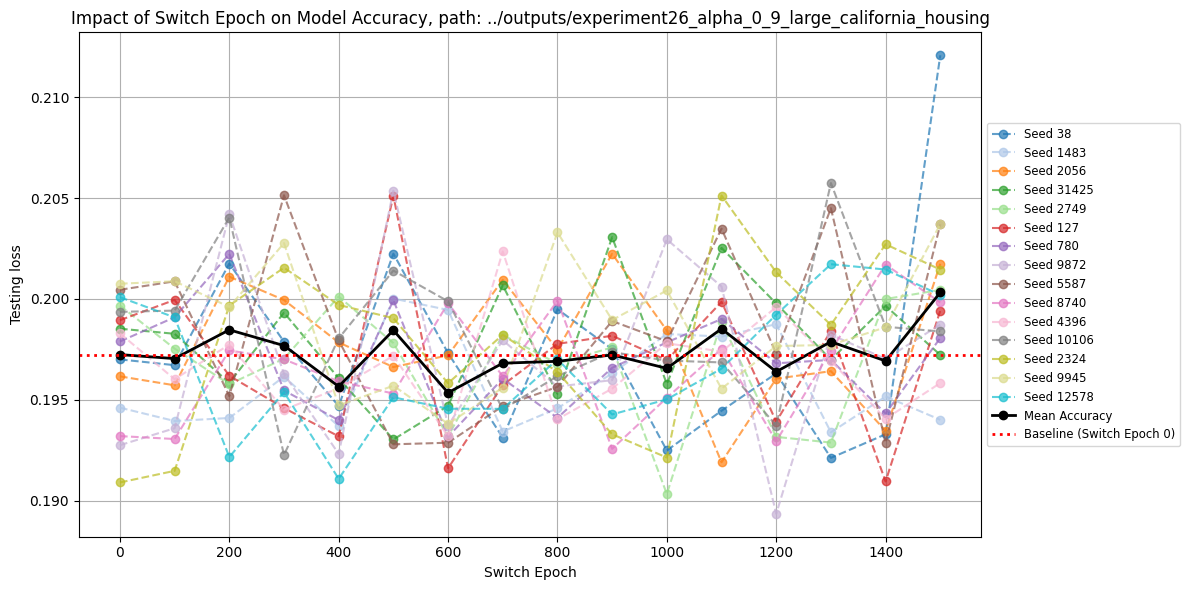

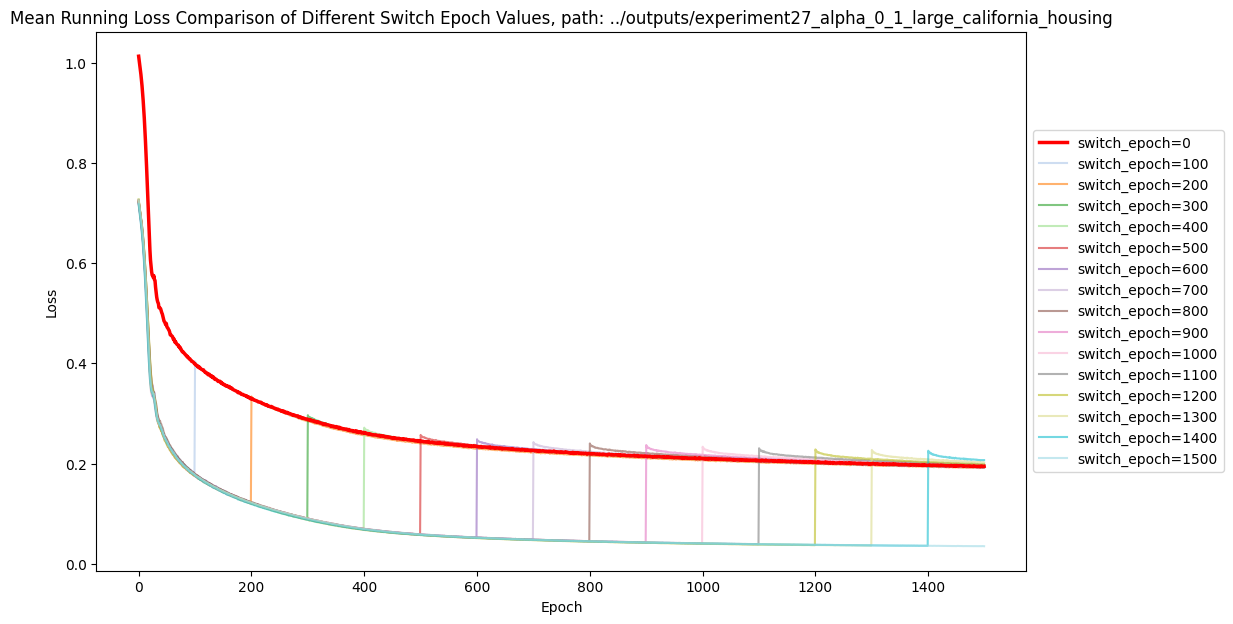

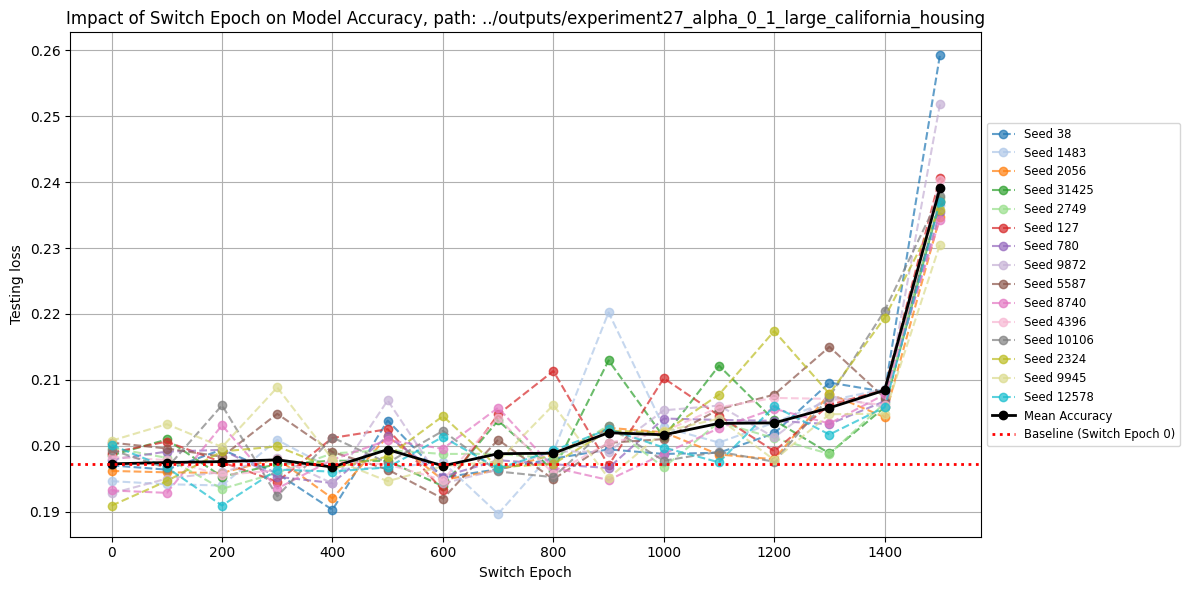

In [22]:
from matplotlib import pyplot as plt
import numpy as np
import os
import re

output_dir = "../outputs"

def extract_experiment_number(name):
    match = re.search(r'experiment(\d+)', name)
    return int(match.group(1)) if match else float('inf')

experiment_paths = sorted(
    [os.path.join(output_dir, d) for d in os.listdir(output_dir) if d.startswith("experiment")],
    key=extract_experiment_number
)

seeds = np.loadtxt("../scripts/seeds.txt", dtype=int).tolist()

for experiment_path in experiment_paths:
    experiment_number = extract_experiment_number(experiment_path)
    if experiment_number < 19:
        continue
    
    switch_epochs = list(range(0, 1501, 100))
    run_accuracies = []
    all_losses = {epoch: [] for epoch in switch_epochs}

    for run, seed in enumerate(seeds):
        results = {}
        switch_epoch_accuracies = []
        
        for switch_epoch in switch_epochs:
            if switch_epoch == 0:
                path = f"../outputs/student_california_housing/model_seed_{seed}"
            else:
                path = f"{experiment_path}/seed_{seed}/switch_epoch_{switch_epoch}"
            
            training_losses = np.loadtxt(f"{path}/training_losses.txt")
            results[switch_epoch] = training_losses
            accuracy = np.loadtxt(f"{path}/accuracy.txt")
            switch_epoch_accuracies.append(accuracy)
            all_losses[switch_epoch].append(training_losses)
        
        run_accuracies.append(switch_epoch_accuracies)

    mean_losses = {epoch: np.mean(all_losses[epoch], axis=0) for epoch in switch_epochs}

    # === PRVNÍ GRAF: Mean Training Loss ===
    plt.figure(figsize=(12, 7))
    colors = plt.cm.tab20(np.linspace(0, 1, len(switch_epochs)))
    
    for idx, (switch_epoch, losses) in enumerate(mean_losses.items()):
        if switch_epoch == 0:
            plt.plot(losses, label=f'switch_epoch={switch_epoch}', color='red', linewidth=2.5, zorder=10)  # Červená, silná čára, v popředí
        else:
            plt.plot(losses, label=f'switch_epoch={switch_epoch}', color=colors[idx], alpha=0.6, linewidth=1.5, zorder=1)  # Světlejší barvy

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Mean Running Loss Comparison of Different Switch Epoch Values, path: {experiment_path}')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    # === DRUHÝ GRAF: Training Loss s Y-lim ===
    # plt.figure(figsize=(12, 7))
    # 
    # for idx, (switch_epoch, losses) in enumerate(mean_losses.items()):
    #     if switch_epoch == 0:
    #         plt.plot(losses, label=f'switch_epoch={switch_epoch}', color='red', linewidth=2.5, zorder=10)
    #     else:
    #         plt.plot(losses, label=f'switch_epoch={switch_epoch}', color=colors[idx], alpha=0.6, linewidth=1.5, zorder=1)
    # 
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title(f'Mean Running Loss Comparison of Different Switch Epoch Values, path: {experiment_path}')
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # plt.ylim(0.14, 0.24)
    # plt.show()

    # === TŘETÍ GRAF: Accuracy ===
    plt.figure(figsize=(12, 6))
    colors = plt.cm.tab20(np.linspace(0, 1, len(switch_epochs)))
    
    for run, seed in enumerate(seeds):
        plt.plot(switch_epochs, run_accuracies[run], marker='o', linestyle='dashed', label=f'Seed {seed}', color=colors[run], alpha=0.7)
    
    mean_accuracies = np.mean(run_accuracies, axis=0)
    plt.plot(switch_epochs, mean_accuracies, marker='o', linestyle='solid', color='black', linewidth=2, label='Mean Accuracy')
    plt.axhline(y=mean_accuracies[0], color='red', linestyle='dotted', linewidth=2, label='Baseline (Switch Epoch 0)')
    
    plt.xlabel('Switch Epoch')
    plt.ylabel('Testing loss')
    plt.title(f'Impact of Switch Epoch on Model Accuracy, path: {experiment_path}')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
    plt.tight_layout()
    plt.grid()
    plt.show()
